In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import env

# from matplotlib import style
import seaborn as sns
%matplotlib inline

# pd.plotting.register_matplotlib_converters()

In [2]:
# Pulled data in sql and cached to csv
df = pd.read_csv('logs.csv')

In [3]:
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


Setting the index to  the date after setting the date to datetime, this will assist in time series analysis.

In [4]:
df.date = pd.to_datetime(df.date)
df = df.set_index('date')
df.head()

,time,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [5]:

pages = df['path'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

plotting number of times ip was hit over a daily period

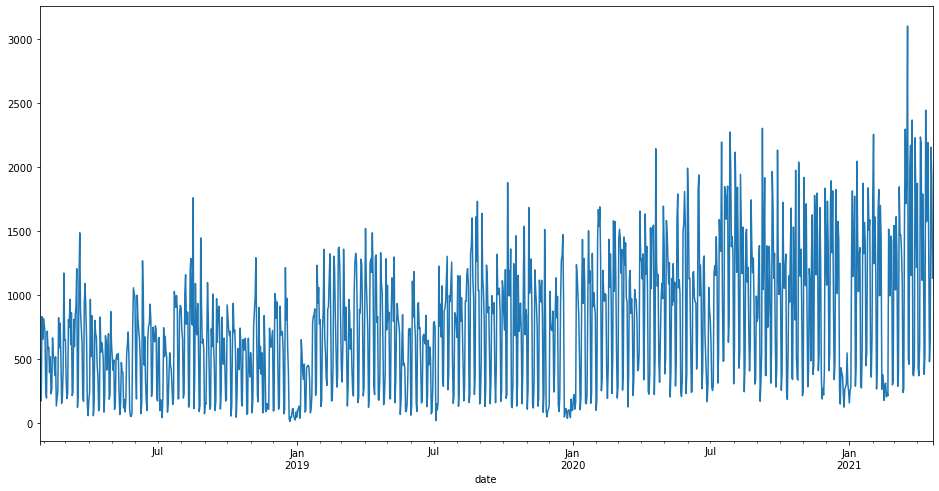

In [6]:
pages.plot(figsize=(16, 8))
plt.show()

No need to split because we are not modeling, we are using statistics to identify low probability cases.

Will be using Exponential Moving Average to assist with the lag that simple moving average gives us, allowing us to more accurately and quickly detect anomolies

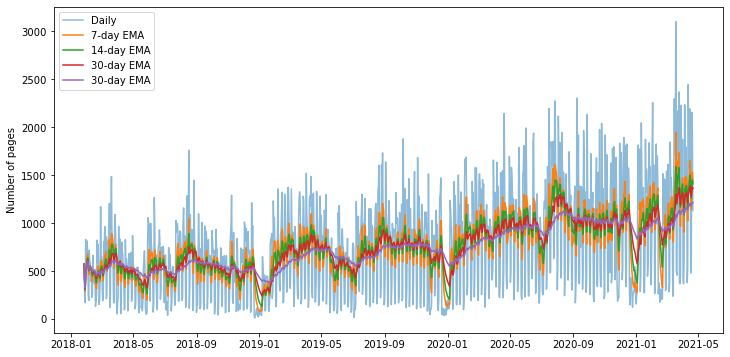

In [7]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

#### Plotted above shows us how with EMA we are able to go through the data and show us across multiple time intervals how often the ip was hit and around what time frames the ip is hit most and least often.

Each data point will have a %b value that represents its relative position within/around the bollinger bands. It answers the question: Where does this point sit relative to a simple range of expected values? 

Bollinger Bands

    a volatility indicator and commonly used in stock market trading.
    Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.

Midband

    The Exponential Moving Average

Upper & Lower Band

    UB/LB = Midband +/- stdev * K
    stdev = train.ewm(span=30).std()
    K = the number of standard deviations to go up and down from the EMA

%b, Percent Bandwidth

    Shows where the last value sits in relation to the bands
    %b > 1 => point lies above UB
    %b < 0 => point lies below LB
    %b == .5 => point lies on the midband.

Bandwidth

    The width of the bands

In [8]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [9]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()


date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: path, dtype: float64

In [10]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub


date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
                 ...     
2021-04-17    3545.216722
2021-04-18    3486.733695
2021-04-19    3569.147958
2021-04-20    3579.231798
2021-04-21    3499.094360
Freq: D, Name: path, Length: 1182, dtype: float64

In [11]:
lb

date
2018-01-26           NaN
2018-01-27   -330.191557
2018-01-28   -326.494835
2018-01-29   -492.401124
2018-01-30   -352.070116
                 ...    
2021-04-17   -894.858492
2021-04-18   -922.334061
2021-04-19   -891.999913
2021-04-20   -825.770723
2021-04-21   -777.340451
Freq: D, Name: path, Length: 1182, dtype: float64

In [12]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [13]:
# Combining all dataframes into one to show tabularly how dates and page hits compare to the bounds and where they fall in bandwith
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


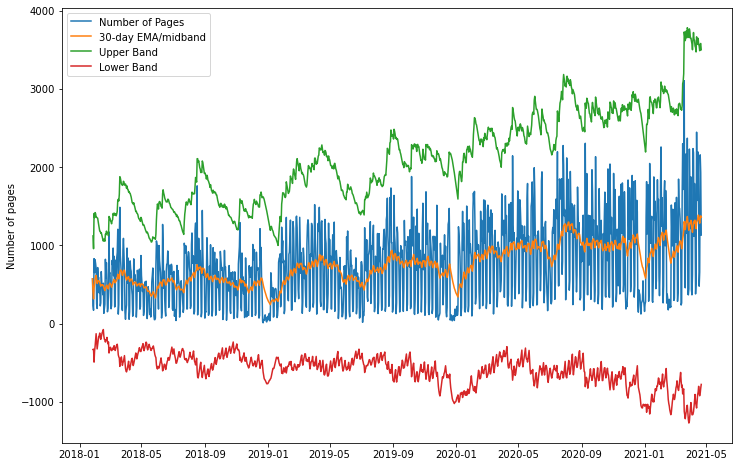

In [14]:
# Plotting the above dataframe.
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

#### We can see that above using the std that we did, not many if any of our pages or dates can be seen as alarming

#### Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b:

In [15]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


Now, where do we see anomalies? We will search for %b values > 1. We don't need to search for values < 0 because with this example, a low extreme is not something we are concerned about.

In [16]:
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


we can see that as thoerized in the exploration, no values fall above 1 in terms of %b. Lets now pull everything we did into functions

In [17]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['path'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

In [18]:
# Pulled data in sql and cached to csv
df = pd.read_csv('logs.csv')
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


Looping the anomoly testing through all users

In [19]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [25]:
# Looking for a high amount of page hits by a user on one day.
anomalies.sort_values('pages', ascending=False)

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2018-06-02,198,16.484863,188.766965,-155.797239,1.026796,138
2019-12-19,192,19.601776,187.231096,-148.027544,1.014225,526
2020-10-16,179,20.158062,173.720239,-133.404115,1.017191,658
2020-06-05,165,20.035882,163.037501,-122.965736,1.006862,521
...,...,...,...,...,...,...
2019-05-21,1,0.064519,0.939144,-0.810106,1.034790,19
2020-11-21,1,0.065202,0.959398,-0.828994,1.022703,410
2019-03-20,1,0.064516,0.939061,-0.810029,1.034841,126


In [26]:
anomalies[anomalies.pages==272]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


seems user 341 somehow has hit up the curriculum 272 times in one day. that's sus

In [28]:
df[df.user_id==341]

,date,time,path,user_id,cohort_id,ip
181808,2019-01-22,15:23:24,/,341,29.0,97.105.19.58
181826,2019-01-22,15:25:51,toc,341,29.0,97.105.19.58
181840,2019-01-22,15:26:44,html-css,341,29.0,97.105.19.58
181862,2019-01-22,15:28:33,html-css/introduction,341,29.0,97.105.19.58
181870,2019-01-22,15:29:29,html-css/elements,341,29.0,97.105.19.58
...,...,...,...,...,...,...
817183,2021-02-09,21:02:55,search/search_index.json,341,29.0,172.124.70.146
817184,2021-02-09,21:03:20,appendix/further-reading/spring/seeder,341,29.0,172.124.70.146
817268,2021-02-10,08:31:18,appendix/code-standards/mysql,341,29.0,172.124.70.146
817269,2021-02-10,08:31:29,appendix/further-reading/spring/pagination,341,29.0,172.124.70.146


seems like our man's going through hecka pages really quickly, perhaps a bot?